In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt

In [2]:
# 한글 깨짐 해결
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#### 데이터 가져오기

In [4]:
df = pd.read_csv('./looker_(datetime).csv')

C:\Users\LG\AppData\Local\Temp\ipykernel_14392\3448098404.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./looker_(datetime).csv')


In [5]:
pd.set_option('display.max_columns', None)
df.head(1)

,user_id,age,gender,account_state,account_city,account_country,latitude,longitude,account_traffic_source,account_created_at,order_id,order_items_id,status,sale_price,order_created_at,shipped_at,delivered_at,returned_at,event_id,session_id,sequence_number,login_user_id,sess_created_at,sess_traffic_source,uri,event_type,ip_address,sess_state,sess_city,inventory_item_id,product_id,category,brand,product_name,inventory_created_at,inventory_sold_at,cost
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1642173.0,0f2ec251-45b7-423e-9b0c-bec0b51f8da9,1.0,NaN,2020-07-07 07:01:00+00:00,Facebook,/product/19439,product,30.255.30.75,Chungcheongnam-do,Asan City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 23년까지 데이터 >> 24년 예측

#### 전처리 함수

In [9]:
# 마지막 값 뽑아내는 함수
def last(x):
    return x.iloc[-1]

# 위험비율, 이탈 여부 라벨링 함수
# 위험비율 = 현재 시점에서의 총 미접속 일수 / 개별 사용자의 평균 접속 주기
# 즉, 개별 사용자의 평균 접속 주기에 비해 지금 얼만큼 심각하게 미접속하고 있는지를 보여줌
def risk_rate_churn_labeling(df):
    # 개별 사용자 별 마지막 접속을 얼마만에 했는지 : diff_days 컬럼
    sess_in_diff = pd.DataFrame(df.groupby('user_id').agg({'account_created_at':'max', 'session_id':'nunique', 'sess_created_at_day': 'unique'}).reset_index())
    # sess_created_at_day를 explode하기 + 날짜 정렬
    sess_in_diff = sess_in_diff.explode('sess_created_at_day').sort_values(by=['user_id', 'sess_created_at_day'])
    # diff구함
    sess_in_diff['diff_days'] = sess_in_diff.groupby('user_id')['sess_created_at_day'].diff().dt.days
    # NaN값 삭제
    sess_in_diff = sess_in_diff.dropna(subset='diff_days')
    # 나중에 필터링 용이하도록 마지막 접속일자의 year 데이터 컬럼 넣어주기 : sess_created_at_year
    sess_in_diff = sess_in_diff.assign(sess_created_at_year = sess_in_diff['sess_created_at_day'].dt.year)


    # 개별 사용자 평균 접속 주기 : diff_days_mean 컬럼 
    sess_in_diff_mean = sess_in_diff.groupby('user_id').agg({'diff_days': lambda x: x.mean().round(2)}).reset_index() #'sess_created_at_day': 'unique'
    sess_in_diff_mean = sess_in_diff_mean.rename(columns = {'diff_days': 'diff_days_mean'})
    sess_in_diff_mean


    # sess_in_diff와 sess_in_diff_mean 조인
    sess_in_diff = sess_in_diff.merge(sess_in_diff_mean, on='user_id', how='outer')


    # 한 시점 데이터
    # 가장 최근 접속한 날짜 >> 유저가 마지막으로 접속한지 얼마나 지났는지
    sess_in_diff = sess_in_diff.groupby('user_id').agg({'sess_created_at_day':'max', 'sess_created_at_year':'max', 'diff_days':last, 'diff_days_mean': 'max'})
    # 현재 시점에서 real_diff_days 구해주기
    sess_in_diff = sess_in_diff.assign(real_diff_days = pd.to_datetime(sess_in_diff['sess_created_at_day'].max()) - pd.to_datetime(sess_in_diff['sess_created_at_day']))
    # timedelta을 초 단위로 변환한 후에 float로 변환
    sess_in_diff = sess_in_diff.assign(real_diff_days_float =sess_in_diff['real_diff_days'].dt.total_seconds() / (24 * 3600))


    # 위험 비율 = real_diff_days / diff_days_mean
    sess_in_diff = sess_in_diff.assign(risk_ratio = (sess_in_diff['real_diff_days_float'] / sess_in_diff['diff_days_mean'])).round(2)
    sess_in_diff


    # 이탈 라벨링
    # churn_tf 컬럼 = (True:이탈, False:활동중)
    sess_in_diff = sess_in_diff.assign(churn_tf = np.where(sess_in_diff['real_diff_days'] > np.timedelta64(90, 'D'), True, False)).reset_index()
    # churn_10 = (True:1, False:0)
    sess_in_diff['churn_10']  = sess_in_diff['churn_tf'].apply(lambda x: 1 if x else 0)
    sess_in_diff = sess_in_diff.rename(columns = {'sess_created_at_day':'sess_created_max_day', 'sess_created_at_year': 'sess_created_max_year'})
    return sess_in_diff


# 기본 전처리
def preprocessing_df(df, year):    
    # sess_created_at_dt 
    df['sess_created_at_dt'] = pd.to_datetime(df['sess_created_at'], format='ISO8601')
    df['sess_created_at_dt'] = df['sess_created_at_dt'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df['sess_created_at_dt'] = pd.to_datetime(df['sess_created_at_dt'], format='%Y-%m-%d %H:%M:%S')
    # sess_created_at_day 
    df['sess_created_at_day'] = df['sess_created_at_dt'].dt.strftime('%Y-%m-%d')
    df['sess_created_at_day'] = pd.to_datetime(df['sess_created_at_day'], format='%Y-%m-%d')
    # sess_created_at_year
    df['sess_created_at_year'] = df['sess_created_at_day'].dt.year
    # sess_created_at_month
    df['sess_created_at_month'] = df['sess_created_at_day'].dt.strftime('%Y.%m')
    # sess_created_only_month
    df['sess_created_only_month'] = df['sess_created_at_day'].dt.month
   
    # account_created_at 타입 변경
    df['account_created_at'] = pd.to_datetime(df['account_created_at'], format='ISO8601')
    # account_created_at_year
    df['account_created_at_year'] = df['account_created_at'].dt.year
    # account_created_at_month
    df['account_created_at_month'] = df['account_created_at'].dt.strftime('%Y.%m')
    # account_created_only_month
    df['account_created_only_month'] = df['account_created_at'].dt.month

    # 필요한 데이터만 가져오기
    # **********************************여기에서 예를들어 23년 이전 데이터를 다 뽑고 싶으면 ==를 <=로 바꿔서 함수 실행한 뒤 사용하기!!****************************************
    df = df[df['account_created_at_year']==year]
    
    # 필요없는 컬럼 drop
    df = df.drop(['account_state', 'account_city', 'account_country', 'latitude', 'longitude', 'order_id', 'order_created_at', 'shipped_at', 'delivered_at', 'returned_at', 'event_id', 'sess_created_at', 'uri', 'ip_address', 'sess_state', 'sess_city', 'inventory_item_id', 'inventory_created_at', 'inventory_sold_at', 'product_id', 'category', 'brand', 'product_name'], axis=1)
    
    # 자체 OneHot Encoding 전처리
    # status, account_traffic_source, sess_traffic_source, event_type
    df_encoding = df.groupby('user_id').agg({'status': lambda x: x.value_counts().to_dict(),
                                           'account_traffic_source':lambda x: x.value_counts().to_dict(),
                                           'sess_traffic_source':lambda x: x.value_counts().to_dict(),
                                           'event_type':lambda x: x.value_counts().to_dict()}).reset_index()
    status_5 = pd.DataFrame(df_encoding['status'].to_list()).fillna(0)
    status_5 = status_5.assign(can_ret_rate = (status_5['Cancelled']+status_5['Returned'])/(status_5['Complete']+status_5['Shipped']+status_5['Processing']+status_5['Cancelled']+status_5['Returned'])).fillna(0)
    acc_traffic = pd.DataFrame(df_encoding['account_traffic_source'].to_list()).fillna(0)
    sess_traffic = pd.DataFrame(df_encoding['sess_traffic_source'].to_list()).fillna(0)
    event_purchase = pd.DataFrame(df_encoding['event_type'].to_list()).fillna(0)
    # 데이터프레임 합치기
    tmp = pd.concat([status_5, acc_traffic, sess_traffic, event_purchase], axis=1)
    df_encoding = pd.concat([df_encoding, tmp],axis=1)
    # 필요없는 컬럼 drop
    df_encoding = df_encoding.drop(['status', 'account_traffic_source', 'sess_traffic_source', 'event_type'], axis=1)
    df_encoding.columns = ['user_id', 'Shipped', 'Cancelled', 'Processing', 'Complete', 'Returned', 'Can_Ret_rate', 'acc_Search', 'acc_Organic', 'acc_Email', 'acc_Facebook', 'acc_Display', 'sess_Email', 'sess_Adwords', 'sess_Organic', 'sess_YouTube', 'sess_Facebook', 'eve_purchase']


    # session_id, sale_price
    # 멀티 인덱스
    sess_sale = df.groupby('user_id').agg({'session_id': 'nunique',
                                            'sale_price':['min', 'max', 'mean', 'std', 'sum']}, as_index=False)
    # 멀티 인덱스 컬럼 설정
    sess_sale.columns = ['{}_{}'.format(col[0], col[1]) if col[1] else col[0] for col in sess_sale.columns]
    sess_sale = sess_sale.fillna(0).reset_index()


    # 전처리 결과 데이터프레임 합치기
    pre_df = df.merge(df_encoding, on='user_id', how='outer')
    pre_df = pre_df.merge(sess_sale, on='user_id', how='outer')
    
    # risk_rate_churn(위험비율, 이탈 라벨링 데이터프레임)
    risk_rate_churn = risk_rate_churn_labeling(df)
    
    # 최종 데이터프레임 만들기
    pre_df = pre_df.merge(risk_rate_churn, on='user_id', how='outer')
    pre_df['churn_tf'] = pre_df['churn_tf'].fillna(True)
    pre_df['churn_10'] = pre_df['churn_10'].fillna(1)
    
    # 그 외 전처리
    # gender (남자 0, 여자 1)
    pre_df['gender'] = pre_df['gender'].apply(lambda x: 0 if x == 'M' else 1)
    # user_id가 없는 비회원들 drop 
    pre_df = pre_df.dropna(subset='user_id')
    
    return pre_df

# 모델 성능평가 함수 
# 정확도, f1-score 함수
def get_score(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') #각 클래스에 대한 F1 스코어를 계산하고, 클래스별 샘플 수에 따라 가중 평균을 계산하여 전체 F1 스코어를 얻음
    print(model_name, ')', 'acc 스코어: ', acc, ',', 'f1 스코어: ', f1)

#### (train) 19~23년 데이터

In [8]:
train_19_23 = preprocessing_df(df, 2023)
train_19_23.head(1)

C:\Users\LG\AppData\Local\Temp\ipykernel_14392\3242205293.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_df['churn_tf'] = pre_df['churn_tf'].fillna(True)


,user_id,age,gender,account_traffic_source,account_created_at,order_items_id,status,sale_price,session_id,sequence_number,login_user_id,sess_traffic_source,event_type,cost,sess_created_at_dt,sess_created_at_day,sess_created_at_year,sess_created_at_month,sess_created_only_month,account_created_at_year,account_created_at_month,account_created_only_month,Shipped,Cancelled,Processing,Complete,Returned,Can_Ret_rate,acc_Search,acc_Organic,acc_Email,acc_Facebook,acc_Display,sess_Email,sess_Adwords,sess_Organic,sess_YouTube,sess_Facebook,eve_purchase,session_id_nunique,sale_price_min,sale_price_max,sale_price_mean,sale_price_std,sale_price_sum,sess_created_max_day,sess_created_max_year,diff_days,diff_days_mean,real_diff_days,real_diff_days_float,risk_ratio,churn_tf,churn_10
0,1.0,62.0,1,Search,2022-03-23,1.0,Shipped,15.0,bccf01cb-6f3b-4ef7-aaff-0ea67e584334,10.0,1.0,Adwords,purchase,6.0,2022-07-20 10:32:05,2022-07-20,2022.0,2022.07,7.0,2022.0,2022.03,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,3,15.0,125.0,53.33,62.118167,159.99,2022-07-20,2022.0,1.0,1.0,548 days,548.0,548.0,True,1.0


#### (test) 24년 데이터
이탈 여부 라벨링된 컬럼(churn_tf, churn_10 드랍)

In [10]:
# churn_tf, churn_10 있는 데이터
df_24 = preprocessing_df(df, 2024)
df_24.head(1)

C:\Users\LG\AppData\Local\Temp\ipykernel_14392\2585052911.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_df['churn_tf'] = pre_df['churn_tf'].fillna(True)


,user_id,age,gender,account_traffic_source,account_created_at,order_items_id,status,sale_price,session_id,sequence_number,login_user_id,sess_traffic_source,event_type,cost,sess_created_at_dt,sess_created_at_day,sess_created_at_year,sess_created_at_month,sess_created_only_month,account_created_at_year,account_created_at_month,account_created_only_month,Shipped,Cancelled,Processing,Complete,Returned,Can_Ret_rate,acc_Search,acc_Organic,acc_Email,acc_Facebook,acc_Display,sess_Email,sess_Adwords,sess_Organic,sess_YouTube,sess_Facebook,eve_purchase,session_id_nunique,sale_price_min,sale_price_max,sale_price_mean,sale_price_std,sale_price_sum,sess_created_max_day,sess_created_max_year,diff_days,diff_days_mean,real_diff_days,real_diff_days_float,risk_ratio,churn_tf,churn_10
0,13.0,54.0,1,Search,2024-01-15,33.0,Processing,100.0,41b5d531-87c6-48f2-a155-4ef96eae9592,5.0,13.0,Email,purchase,43.8,2024-01-16 12:32:37,2024-01-16,2024.0,2024.01,1.0,2024.0,2024.01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2,27.950001,100.0,63.975,50.947043,127.950001,NaT,NaN,NaN,NaN,NaT,NaN,NaN,True,1.0


In [11]:
# churn_tf, churn_10 날린 데이터
test_24 = df_24.drop(['churn_tf', 'churn_10'], axis=1)
test_24.head(1)

,user_id,age,gender,account_traffic_source,account_created_at,order_items_id,status,sale_price,session_id,sequence_number,login_user_id,sess_traffic_source,event_type,cost,sess_created_at_dt,sess_created_at_day,sess_created_at_year,sess_created_at_month,sess_created_only_month,account_created_at_year,account_created_at_month,account_created_only_month,Shipped,Cancelled,Processing,Complete,Returned,Can_Ret_rate,acc_Search,acc_Organic,acc_Email,acc_Facebook,acc_Display,sess_Email,sess_Adwords,sess_Organic,sess_YouTube,sess_Facebook,eve_purchase,session_id_nunique,sale_price_min,sale_price_max,sale_price_mean,sale_price_std,sale_price_sum,sess_created_max_day,sess_created_max_year,diff_days,diff_days_mean,real_diff_days,real_diff_days_float,risk_ratio
0,13.0,54.0,1,Search,2024-01-15,33.0,Processing,100.0,41b5d531-87c6-48f2-a155-4ef96eae9592,5.0,13.0,Email,purchase,43.8,2024-01-16 12:32:37,2024-01-16,2024.0,2024.01,1.0,2024.0,2024.01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2,27.950001,100.0,63.975,50.947043,127.950001,NaT,NaN,NaN,NaN,NaT,NaN,NaN


### RF 모델링

#### RandomizedSearchCV

- 파라미터 값 최소로 주고 시간 확인하기

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV

# X, y 정의
X_features = ['age', 'gender', 'Shipped', 'Cancelled', 'Processing', 'Complete', 'Returned', 'Can_Ret_rate', 
              'acc_Search', 'acc_Organic', 'acc_Email', 'acc_Facebook', 'acc_Display', 'sess_Email', 
              'sess_Adwords', 'sess_Organic', 'sess_YouTube', 'sess_Facebook', 'eve_purchase', 
              'session_id_nunique', 'sale_price_min', 'sale_price_max', 'sale_price_mean', 
              'sale_price_std', 'sale_price_sum']

X = train_19_23[X_features]
y = train_19_23['churn_10']

# train / test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 X_train, y_train 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후  X_train, y_train 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

# 모델 생성
model_rf = RandomForestClassifier(random_state=42, class_weight= 'balanced')

# 탐색할 하이퍼파라미터 그리드 설정
param_rf = {
            'max_depth' : [5],
            'max_features' : [5],
            'min_samples_leaf' : [100],
            'n_estimators' : [200]
            }

# RandomizedSearchCV
rscv_rf = RandomizedSearchCV(model_rf,
                            param_distributions= param_rf, # 파라미터 입력
                            n_iter = 500,   # random search 탐색 횟수
                            cv = 2,        # cv 검증을 위한 분할 검증 횟수
                            scoring='f1',  # 오차 평가방법
                            verbose=1,     # 진행상황
                            random_state = 42
                            )

# RandomizedSearchCV 수행
rscv_rf.fit(X_train_over, y_train_over)

# 최적의 하이퍼파라미터 출력
print("Best RF Parameters:", rscv_rf.best_params_)
print('Best RF Score: {:.4f}'.format(rscv_rf.best_score_))


# 최적의 하이퍼파라미터로 모델 초기화
best_model = rscv_rf.best_estimator_

# 모델 훈련
best_model.fit(X_train_over, y_train_over)

SMOTE 적용 전 X_tr, y_tr 데이터 세트 :  (128242, 25) (128242,)
SMOTE 적용 후  X_tr, y_tr 데이터 세트 : (207696, 25) (207696,)
SMOTE 적용 후 값의 분포 :
 churn_10
0.0    103848
1.0    103848
Name: count, dtype: int64
Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\LG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=500. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best RF Parameters: {'n_estimators': 200, 'min_samples_leaf': 100, 'max_features': 5, 'max_depth': 5}
Best RF Score: 0.6907


RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=5,
                       min_samples_leaf=100, n_estimators=200, random_state=42)

In [15]:
# 테스트 데이터에 대한 예측
y_pred = best_model.predict(X_test)

# 모델 평가
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 5505   594]
 [11559 14403]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.32      0.90      0.48      6099
         1.0       0.96      0.55      0.70     25962

    accuracy                           0.62     32061
   macro avg       0.64      0.73      0.59     32061
weighted avg       0.84      0.62      0.66     32061



- 넣고싶은 파라미터 다 넣어보기

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV

# X, y 정의
X_features = ['age', 'gender', 'Shipped', 'Cancelled', 'Processing', 'Complete', 'Returned', 'Can_Ret_rate', 
              'acc_Search', 'acc_Organic', 'acc_Email', 'acc_Facebook', 'acc_Display', 'sess_Email', 
              'sess_Adwords', 'sess_Organic', 'sess_YouTube', 'sess_Facebook', 'eve_purchase', 
              'session_id_nunique', 'sale_price_min', 'sale_price_max', 'sale_price_mean', 
              'sale_price_std', 'sale_price_sum']

X = train_19_23[X_features]
y = train_19_23['churn_10']

# train / test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 X_train, y_train 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후  X_train, y_train 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

# 모델 생성
model_rf = RandomForestClassifier(random_state=42, class_weight= 'balanced')

# 탐색할 하이퍼파라미터 그리드 설정
param_rf = {
            'max_depth' : [3, 5, 10, 15],
            'max_features' : [3, 5, 10, 15],
            'min_samples_leaf' : [70, 100, 120, 150],
            'n_estimators' : [80, 100, 150, 200]
}

# RandomizedSearchCV
rscv_rf = RandomizedSearchCV(model_rf,
                            param_distributions=param_rf, # 파라미터 입력
                            n_iter = 500,   # random search 탐색 횟수
                            cv = 5,        # cv 검증을 위한 분할 검증 횟수
                            scoring='f1',  # 오차 평가방법
                            verbose=1,     # 진행상황
                            random_state = 42
                            )

# RandomizedSearchCV 수행
rscv_rf.fit(X_train_over, y_train_over)

# 최적의 하이퍼파라미터 출력
print("Best RF Parameters:", rscv_rf.best_params_)
print('Best RF Score: {:.4f}'.format(rscv_rf.best_score_))


# 최적의 하이퍼파라미터로 모델 초기화
best_model = rscv_rf.best_estimator_

# 모델 훈련
best_model.fit(X_train_over, y_train_over)

SMOTE 적용 전 X_train, y_train 데이터 세트 :  (128242, 25) (128242,)
SMOTE 적용 후  X_train, y_train 데이터 세트 : (207696, 25) (207696,)
SMOTE 적용 후 값의 분포 :
 churn_10
0.0    103848
1.0    103848
Name: count, dtype: int64
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


c:\Users\LG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 256 is smaller than n_iter=500. Running 256 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best RF Parameters: {'n_estimators': 200, 'min_samples_leaf': 70, 'max_features': 15, 'max_depth': 15}
Best RF Score: 0.8262


RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=15,
                       min_samples_leaf=70, n_estimators=200, random_state=42)

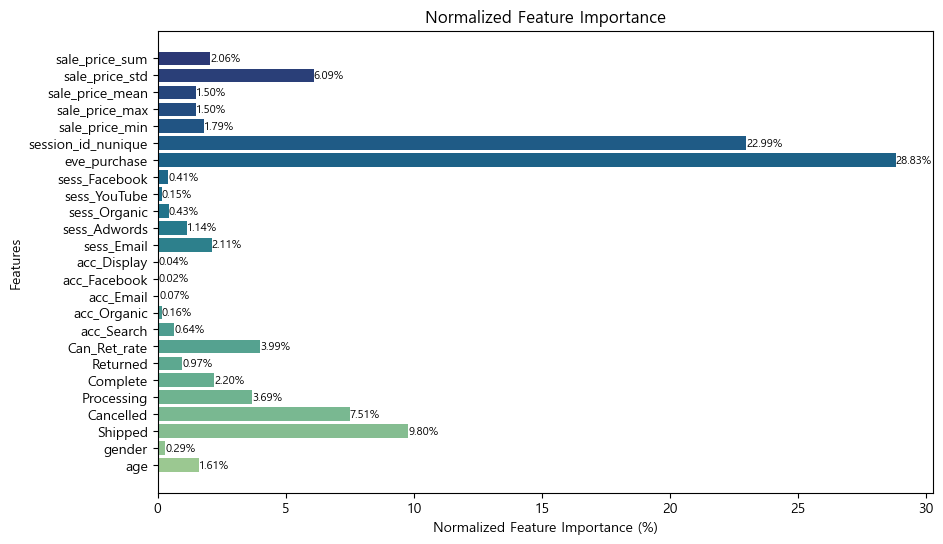

In [21]:
# 특성 중요도
feature_imp = best_model.feature_importances_

# feature importance 100%로 정규화
total_importance = np.sum(feature_imp)
normalized_importance = (feature_imp / total_importance) * 100

# 시각화
pastel_colors = sns.color_palette("crest", n_colors=len(X.columns)) #"pastel", n_colors=len(X.columns)

# 정규화 feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(normalized_importance)), normalized_importance, align='center', color=pastel_colors)
plt.yticks(range(len(normalized_importance)), X.columns) 
plt.xlabel('Normalized Feature Importance (%)')
plt.ylabel('Features')
plt.title('Normalized Feature Importance')

# 수치 표현
for bar, importance in zip(bars, normalized_importance):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{importance:.2f}%', 
             va='center', ha='left', fontsize=8)

plt.show()

C:\Users\LG\AppData\Local\Temp\ipykernel_12380\1078842166.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_rf, x='Feature', y='Importance', palette='crest')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


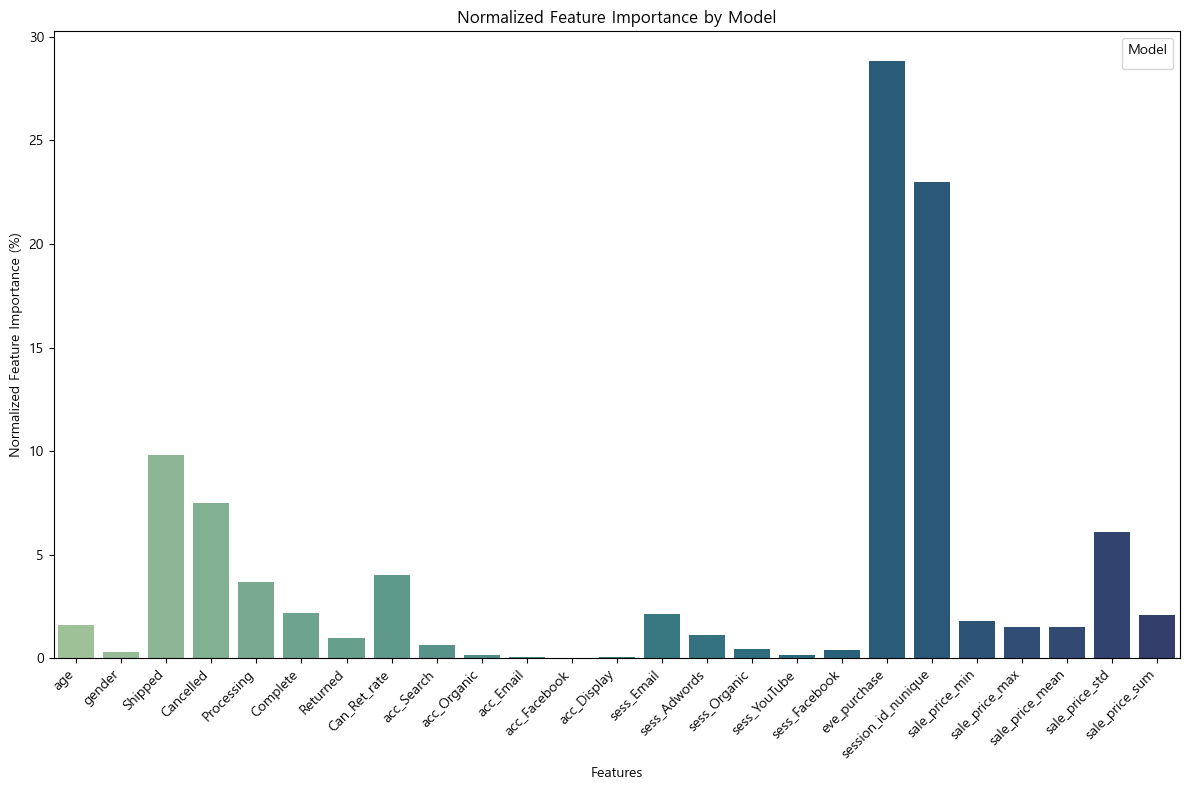

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 각 모델의 특성 중요도를 DataFrame으로 변환
best_rf = pd.DataFrame({'Feature': X.columns, 'Importance': normalized_importance, 'Model': 'RandomForest'})
#pastel_colors = sns.color_palette("crest", n_colors=len(X.columns)) #"pastel", n_colors=len(X.columns)

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=best_rf, x='Feature', y='Importance', palette='crest')
plt.xlabel('Features')
plt.ylabel('Normalized Feature Importance (%)')
plt.title('Normalized Feature Importance by Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')

plt.tight_layout()
plt.show()

In [17]:
# 테스트 데이터에 대한 예측
y_pred = best_model.predict(X_test)

# 모델 평가
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 3717  2382]
 [ 4740 21222]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.61      0.51      6099
         1.0       0.90      0.82      0.86     25962

    accuracy                           0.78     32061
   macro avg       0.67      0.71      0.68     32061
weighted avg       0.81      0.78      0.79     32061



In [19]:
# 진짜 테스트 데이터에 대한 예측
y_pred_test = best_model.predict(test_24[X_features])

# 모델 평가
conf_matrix_test = confusion_matrix(df_24['churn_10'], y_pred_test)
print("Confusion Matrix (Real Test Data):")
print(conf_matrix_test)

class_report_test = classification_report(df_24['churn_10'], y_pred_test)
print("Classification Report (Real Test Data):")
print(class_report_test)

Confusion Matrix (Real Test Data):
[[1543 1139]
 [ 319 2539]]
Classification Report (Real Test Data):
              precision    recall  f1-score   support

         0.0       0.83      0.58      0.68      2682
         1.0       0.69      0.89      0.78      2858

    accuracy                           0.74      5540
   macro avg       0.76      0.73      0.73      5540
weighted avg       0.76      0.74      0.73      5540



#### GridSearchCV 
(시간이 너무 오래 걸리니 돌리지 않는 걸 추천)

- 파라미터 값 최소로 주고 시간 확인하기

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

# X, y 정의
X_features = ['age', 'gender', 'Shipped', 'Cancelled', 'Processing', 'Complete', 'Returned', 'Can_Ret_rate', 
              'acc_Search', 'acc_Organic', 'acc_Email', 'acc_Facebook', 'acc_Display', 'sess_Email', 
              'sess_Adwords', 'sess_Organic', 'sess_YouTube', 'sess_Facebook', 'eve_purchase', 
              'session_id_nunique', 'sale_price_min', 'sale_price_max', 'sale_price_mean', 
              'sale_price_std', 'sale_price_sum']

X = train_19_23[X_features]
y = train_19_23['churn_10']

# train / test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 X_tr, y_tr 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후  X_tr, y_tr 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

# 모델 생성
model_rf = RandomForestClassifier(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_rf = {
    'n_estimators': [500],
    'max_depth': [30]
}

# 그리드 서치 수행
gscv_rf = GridSearchCV(model_rf, param_grid=param_rf, cv=2, scoring='f1')
gscv_rf.fit(X_train_over, y_train_over)

# 최적의 하이퍼파라미터 출력
print("Best RF Parameters:", gscv_rf.best_params_)
print('Best RF Score: {:.4f}'.format(gscv_rf.best_score_))

# 최적의 하이퍼파라미터로 모델 초기화
best_model = gscv_rf.best_estimator_

# 모델 훈련
best_model.fit(X_train_over, y_train_over)

In [ ]:
# 테스트 데이터에 대한 예측
y_pred = best_model.predict(X_test)

# 모델 평가
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [ ]:
# 진짜 테스트 데이터에 대한 예측
y_pred_test = model_rf.predict(test_24[X_features])

# 모델 평가
conf_matrix_test = confusion_matrix(df_24['churn_10'], y_pred_test)
print("Confusion Matrix (Real Test Data):")
print(conf_matrix_test)

class_report_test = classification_report(df_24['churn_10'], y_pred_test)
print("Classification Report (Real Test Data):")
print(class_report_test)